Look at the feature importances in the models from earlier tuning .

Actually... would be kind of cool to try to plot top features against accuracy

In [1]:
import pandas as pd
import numpy as np
import datetime; import pytz
import matplotlib.pyplot as plt
from joblib import dump, load
import joblib
import os
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from functools import reduce
import fresh.s3utils as fs3
from importlib import reload
import json
import fresh.plot as fp
import fresh.vanilla_utils as fvu
import fresh.metrics as fm

import fresh.utils as fu


In [11]:
artifactsdir = '/opt/program/artifacts/2020-07-10T135910Z'
alldf = pd.read_csv(f'{artifactsdir}/train+test_results_vec.csv')
alldf.iloc[0]


train_acc                   0.00797076
train_balanced_acc           0.0185185
i                                  868
train_logloss                  34.2635
train_karea                   0.473045
max_depth                            4
learning_rate                        1
objective               multi:softprob
num_class                           54
base_score                         0.5
booster                         gbtree
colsample_bylevel                  0.1
colsample_bynode                     1
colsample_bytree                   0.1
gamma                                0
max_delta_step                       0
min_child_weight                     1
random_state                         0
reg_alpha                            0
reg_lambda                           1
scale_pos_weight                     1
seed                                42
subsample                          0.4
verbosity                            0
acc                         0.00806245
balanced_acc             

In [12]:
# bundle feature access..
def features_from_model(i):
    bundle_loc = f'{artifactsdir}/{i}_bundle_with_metrics.joblib'
    bundle = joblib.load(bundle_loc)
    model = bundle['xgb_model']
    return bundle, model
    
bundle, model = features_from_model(868)

In [13]:
len(model.feature_names), 

(85,)

In [14]:
bundle

{'notebook': '2020-07-10-aws.ipynb',
 'xgb_model': <xgboost.core.Booster at 0x7f076b88be10>,
 'train': '/home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-08T143732Z/train.libsvm',
 'walltime': 718.513401,
 'primary_dataset': '2013-07 - Citi Bike trip data.csv',
 'input_params': {'max_depth': 4,
  'learning_rate': 1,
  'objective': 'multi:softprob',
  'num_class': 54,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 0.1,
  'colsample_bynode': 1,
  'colsample_bytree': 0.1,
  'gamma': 0,
  'max_delta_step': 0,
  'min_child_weight': 1,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': 42,
  'subsample': 0.4,
  'verbosity': 0},
 'num_round': 80,
 'validation_metrics': {'accuracy': 0.008062450795337057,
  'balanced_accuracy': 0.018518518518518517,
  'confusion': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 

In [15]:
# from the bundle ^^ I also download the processing bundle... 
# by looking at the notebook, https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-07-10-aws.md
# for reference.
datadir = f'/opt/program/artifacts/2020-07-08T143732Z'
proc_bundle = joblib.load(f'{datadir}/proc_bundle.joblib')

'artifacts/2020-07-08T143732Z/proc_bundle.joblib'

'artifacts/2020-07-08T143732Z/proc_bundle.joblib'

In [16]:
proc_bundle

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'notebook': '2020-07-03-aws.ipynb',
 'proc_bundle': {'enc': OneHotEncoder(categories=[['Alphabet City', 'Battery Park City',
                             'Bedford-Stuyvesant', 'Bloomingdale', 'Boerum Hill',
                             'Bowery', 'Broadway Triangle', 'Brooklyn Heights',
                             'Brooklyn Navy Yard', 'Carnegie Hill',
                             'Carroll Gardens', 'Central Park', 'Chelsea',
                             'Chinatown', 'Civic Center', 'Clinton Hill',
                             'Cobble Hill', 'Columbia Street Waterfront District',
                             'Downtown Brooklyn', 'Dumbo', 'East Harlem',
                             'East Village', 'East Williamsburg',
                             'Financial District', 'Flatiron District',
                             'Fort Greene', 'Fulton Ferry District',
                             'Garment District', 'Governors Island', 'Gowanus', ...],
                            [0, 1, 2], [0, 1,

In [ ]:
# Now taking a look at the notebook https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-07-03-aws.md
# referred to in the proc_bundle, I note that this bundle uses the `v2` preprocessing
# So features , looking at fresh/preproc/v2.py , the xform  func, 
# (Also refreshing my mind about the data going into preproc, looking at prepare_data in fresh/utils.py)
# 
# There's 85 features
# so the first 83 come from the OneHotEncoder, [neighborhoods, genders, time_of_day]
# Then the usertype label encoder
# And finally the last column is taken as is, which is just the weekday, 


In [20]:
[len(x) for x in proc_bundle['proc_bundle']['enc'].categories]

[75, 3, 5]

array(['Customer', 'Subscriber'], dtype=object)

In [28]:
onehot = proc_bundle['proc_bundle']['enc'].categories
usertypes = proc_bundle['proc_bundle']['usertype_le'].classes_
feature_names = ([f'start_neighborhood={x}' for x in onehot[0]] 
                + [f'gender={x}' for x in onehot[1]]
                + [f'time_of_day={x}' for x in onehot[2]]
                + ['usertype']
                + ['weekday']) 
feature_names, len(feature_names)

(['start_neighborhood=Alphabet City',
  'start_neighborhood=Battery Park City',
  'start_neighborhood=Bedford-Stuyvesant',
  'start_neighborhood=Bloomingdale',
  'start_neighborhood=Boerum Hill',
  'start_neighborhood=Bowery',
  'start_neighborhood=Broadway Triangle',
  'start_neighborhood=Brooklyn Heights',
  'start_neighborhood=Brooklyn Navy Yard',
  'start_neighborhood=Carnegie Hill',
  'start_neighborhood=Carroll Gardens',
  'start_neighborhood=Central Park',
  'start_neighborhood=Chelsea',
  'start_neighborhood=Chinatown',
  'start_neighborhood=Civic Center',
  'start_neighborhood=Clinton Hill',
  'start_neighborhood=Cobble Hill',
  'start_neighborhood=Columbia Street Waterfront District',
  'start_neighborhood=Downtown Brooklyn',
  'start_neighborhood=Dumbo',
  'start_neighborhood=East Harlem',
  'start_neighborhood=East Village',
  'start_neighborhood=East Williamsburg',
  'start_neighborhood=Financial District',
  'start_neighborhood=Flatiron District',
  'start_neighborhood=Fo

In [21]:
[x for x in proc_bundle['proc_bundle']['enc'].categories]
['start_neighborhood', 'gender', 'time_of_day', 'usertype', 'weekday', ]

[['Alphabet City',
  'Battery Park City',
  'Bedford-Stuyvesant',
  'Bloomingdale',
  'Boerum Hill',
  'Bowery',
  'Broadway Triangle',
  'Brooklyn Heights',
  'Brooklyn Navy Yard',
  'Carnegie Hill',
  'Carroll Gardens',
  'Central Park',
  'Chelsea',
  'Chinatown',
  'Civic Center',
  'Clinton Hill',
  'Cobble Hill',
  'Columbia Street Waterfront District',
  'Downtown Brooklyn',
  'Dumbo',
  'East Harlem',
  'East Village',
  'East Williamsburg',
  'Financial District',
  'Flatiron District',
  'Fort Greene',
  'Fulton Ferry District',
  'Garment District',
  'Governors Island',
  'Gowanus',
  'Gramercy Park',
  'Greenpoint',
  'Greenwich Village',
  "Hell's Kitchen",
  'Hudson Square',
  'Hunters Point',
  'Kips Bay',
  'Korea Town',
  'Lenox Hill',
  'Lincoln Square',
  'Little Italy',
  'Long Island City',
  'Lower East Side',
  'Lower Manhattan',
  'Meatpacking District',
  'Midtown',
  'Midtown East',
  'Midtown West',
  'Murray Hill',
  'NoHo',
  'NoMad',
  'Nolita',
  'Park S

In [22]:
proc_bundle['proc_bundle']['enc']

OneHotEncoder(categories=[['Alphabet City', 'Battery Park City',
                           'Bedford-Stuyvesant', 'Bloomingdale', 'Boerum Hill',
                           'Bowery', 'Broadway Triangle', 'Brooklyn Heights',
                           'Brooklyn Navy Yard', 'Carnegie Hill',
                           'Carroll Gardens', 'Central Park', 'Chelsea',
                           'Chinatown', 'Civic Center', 'Clinton Hill',
                           'Cobble Hill', 'Columbia Street Waterfront District',
                           'Downtown Brooklyn', 'Dumbo', 'East Harlem',
                           'East Village', 'East Williamsburg',
                           'Financial District', 'Flatiron District',
                           'Fort Greene', 'Fulton Ferry District',
                           'Garment District', 'Governors Island', 'Gowanus', ...],
                          [0, 1, 2], [0, 1, 2, 3, 4]],
              drop=None, dtype=<class 'numpy.float64'>, handle_unknown='e

In [56]:
len(model.get_score(importance_type='gain')),len(model.get_score(importance_type='weight'))
features = {f'f{i}': model.get_score(importance_type='gain').get(f'f{i}', 0)
               for i, x in enumerate(model.feature_names)}
features

{'f0': 21.84926239047878,
 'f1': 37.786746494099994,
 'f2': 433.8485397055555,
 'f3': 0,
 'f4': 16.223508027632352,
 'f5': 9.42196043241206,
 'f6': 0,
 'f7': 312.1357001213905,
 'f8': 183.591148200835,
 'f9': 0,
 'f10': 0,
 'f11': 677.8533162,
 'f12': 38.99434604246625,
 'f13': 6.5263488942345464,
 'f14': 26.45729177064285,
 'f15': 175.7688860563296,
 'f16': 0,
 'f17': 90.76833475265924,
 'f18': 72.15264768027933,
 'f19': 21.99337013682858,
 'f20': 0,
 'f21': 10.54046058378206,
 'f22': 0,
 'f23': 17.879153117563337,
 'f24': 3.570255177766334,
 'f25': 84.93661638680767,
 'f26': 430.67800551271426,
 'f27': 4.882921038958334,
 'f28': 0,
 'f29': 0,
 'f30': 4.647248752257143,
 'f31': 0,
 'f32': 6.513139701477776,
 'f33': 44.31525139833,
 'f34': 9.75682808103667,
 'f35': 0,
 'f36': 12.14313110033871,
 'f37': 3.478033674544285,
 'f38': 0,
 'f39': 31.03448123228923,
 'f40': 4.873982171226924,
 'f41': 0,
 'f42': 33.41495056715625,
 'f43': 3.9420541673342404,
 'f44': 1.783668180384583,
 'f45': 1

In [51]:
# oops some how got two of these, but exactly the same so can drop one
alldf[alldf['i'] == 0].T
alldf = alldf.drop_duplicates(subset='i')

In [52]:
# alldf[alldf['i'] == 0].T
alldf.

,262
train_acc,0.0527632
train_balanced_acc,0.0372754
i,0
train_logloss,3.97656
train_karea,0.643525
max_depth,3
learning_rate,0.01
objective,multi:softprob
num_class,54
base_score,0.5


In [70]:
# bundle feature access..
def feature_stats_from_model(alldf, i):
    bundle_loc = f'{artifactsdir}/{i}_bundle_with_metrics.joblib'
    bundle = joblib.load(bundle_loc)
    model = bundle['xgb_model']
    # return bundle, model
    row = alldf[alldf['i'] == i].iloc[0]
    features = {f'f{i}': model.get_score(importance_type='gain').get(f'f{i}', 0)
               for i, x in enumerate(model.feature_names)}
    return {**features, 'acc': float(row.acc), 'karea': float(row.karea)}

row = feature_stats_from_model(alldf, 868)
row

{'f0': 21.84926239047878,
 'f1': 37.786746494099994,
 'f2': 433.8485397055555,
 'f3': 0,
 'f4': 16.223508027632352,
 'f5': 9.42196043241206,
 'f6': 0,
 'f7': 312.1357001213905,
 'f8': 183.591148200835,
 'f9': 0,
 'f10': 0,
 'f11': 677.8533162,
 'f12': 38.99434604246625,
 'f13': 6.5263488942345464,
 'f14': 26.45729177064285,
 'f15': 175.7688860563296,
 'f16': 0,
 'f17': 90.76833475265924,
 'f18': 72.15264768027933,
 'f19': 21.99337013682858,
 'f20': 0,
 'f21': 10.54046058378206,
 'f22': 0,
 'f23': 17.879153117563337,
 'f24': 3.570255177766334,
 'f25': 84.93661638680767,
 'f26': 430.67800551271426,
 'f27': 4.882921038958334,
 'f28': 0,
 'f29': 0,
 'f30': 4.647248752257143,
 'f31': 0,
 'f32': 6.513139701477776,
 'f33': 44.31525139833,
 'f34': 9.75682808103667,
 'f35': 0,
 'f36': 12.14313110033871,
 'f37': 3.478033674544285,
 'f38': 0,
 'f39': 31.03448123228923,
 'f40': 4.873982171226924,
 'f41': 0,
 'f42': 33.41495056715625,
 'f43': 3.9420541673342404,
 'f44': 1.783668180384583,
 'f45': 1

In [69]:
row = alldf[alldf['i'] == 0]
float(row.iloc[0].acc)

0.050964174262760016

In [71]:
stats_vec = []
for i in tqdm(alldf['i'].tolist()):
    stats_vec.append(feature_stats_from_model(alldf, i))

100%|██████████| 1253/1253 [3:43:03<00:00, 10.68s/it]  


In [74]:
foodf = pd.DataFrame.from_records(stats_vec)
foodf.corr().to_csv(f'{artifactsdir}/feature_acc_corr.csv')

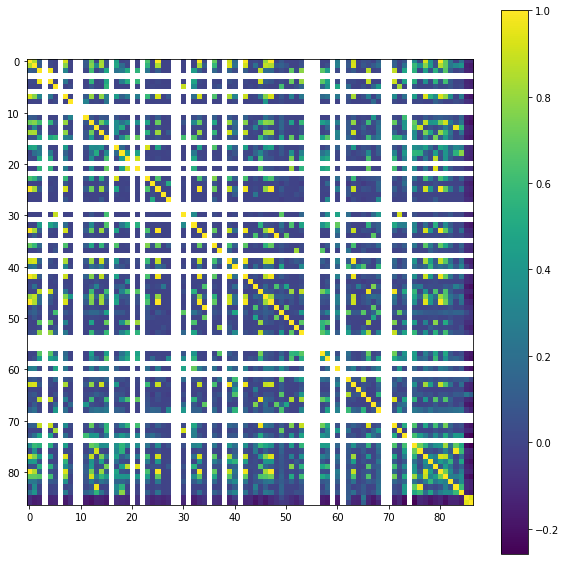

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(foodf.corr())
plt.colorbar()
plt.grid(False)
plt.show()


This is an attempt to see which features being important correlates with higher accuracy. I guess this is another way of asking the question, given the higher accuracy models, do they share some of the top features?

Basically is there a trend there or is it pretty random.

In [77]:
foodf.iloc[0]

f0        21.849262
f1        37.786746
f2       433.848540
f3         0.000000
f4        16.223508
            ...    
f82       12.161109
f83       46.388669
f84        4.034771
acc        0.008062
karea      0.472606
Name: 0, Length: 87, dtype: float64

In [81]:
foodf['i'] = alldf['i'].tolist()

In [84]:
foodf.sort_values(by='acc').to_csv(f'{artifactsdir}/feature_importances.csv')

In [91]:
foodf.corr().sort_values(by='acc')['acc'].tolist()

[-0.22249028433987125,
 -0.2146619609978095,
 -0.18244263134367497,
 -0.17365844155587123,
 -0.17290120681000407,
 -0.1671679775812512,
 -0.1667816434203584,
 -0.1618100863720859,
 -0.15993725926056238,
 -0.1571657789494311,
 -0.15691696599470017,
 -0.15359107691068863,
 -0.1526146337471444,
 -0.15192954875843095,
 -0.14988719316482935,
 -0.1485679345446469,
 -0.14848568392802328,
 -0.14148592302023344,
 -0.14044175116931404,
 -0.12903514620585077,
 -0.12866145769710494,
 -0.12781799189987822,
 -0.1277534168716233,
 -0.12450423647018186,
 -0.11960031267262315,
 -0.11902185698543191,
 -0.11827748747262198,
 -0.11729214357164451,
 -0.11526483521004573,
 -0.11506083639110845,
 -0.11347420363145143,
 -0.11313720499150802,
 -0.11225904071671343,
 -0.11163087167685924,
 -0.11101930170239466,
 -0.11063757047545346,
 -0.11047868892759936,
 -0.10947215709446233,
 -0.10883598231327433,
 -0.10686461955713056,
 -0.10533517240859021,
 -0.10142423745196777,
 -0.10128485600188009,
 -0.099991404040842

In [92]:
foodf.corr().sort_values(by='acc')['acc']

f75   -0.222490
f73   -0.214662
f81   -0.182443
f12   -0.173658
f78   -0.172901
         ...   
f59         NaN
f61         NaN
f69         NaN
f70         NaN
f74         NaN
Name: acc, Length: 88, dtype: float64

In [97]:
feature_map = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

In [98]:
#foodf.corr().sort_values(by='acc')['acc']
foodf.to_records?

In [114]:

x = foodf.corr().sort_values(by='acc')['acc'].index.tolist()
[x[i]  for (i, _) in enumerate(x)
         if feature_map.get(x[i]) is None]


['i', 'karea', 'acc']

### 2020-07-31

#### represent as horizontal bar chart...
- this figure below looks interesting but still the correlations are I think way too small to be interesting.
- That being said, looking at a correlation between two quantities like accuracy (float between 0 and ~0.12) and xgboost feature weight (unbounded number that can be 0, 2, 100, 400 or more), maybe is not proper. Perhaps the numbers need to be normalized?

<BarContainer object of 64 artists>

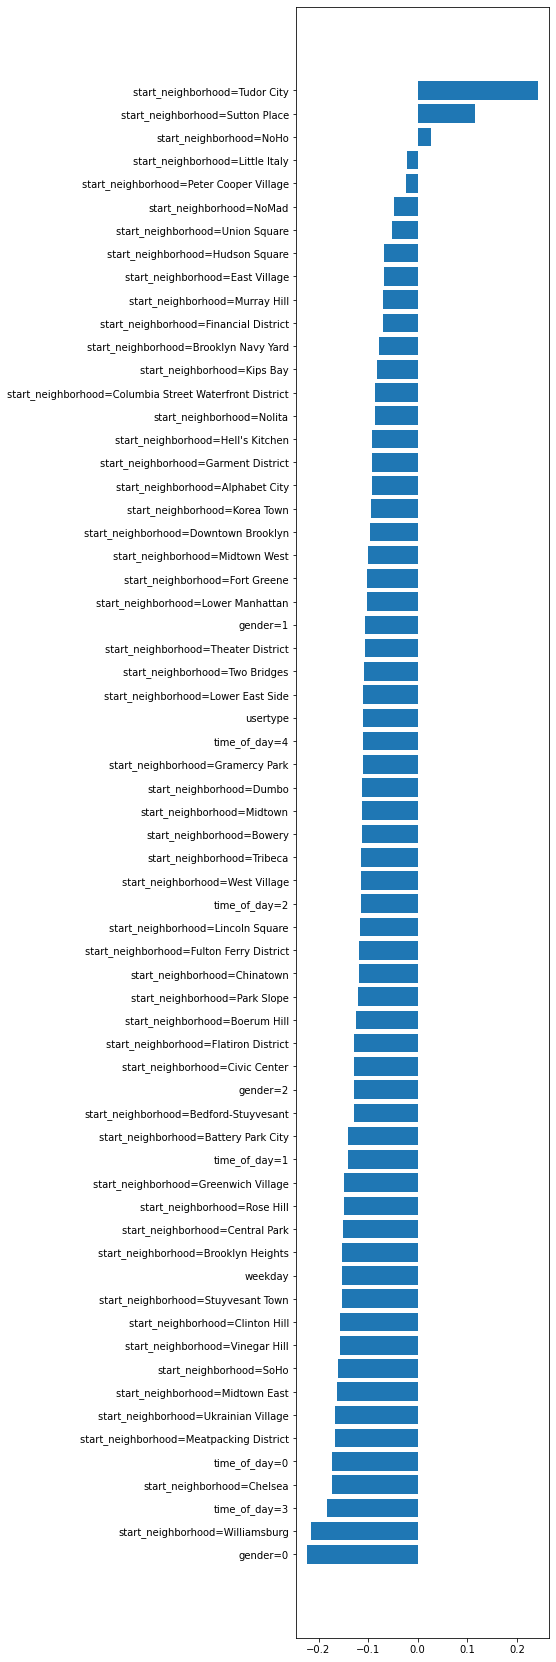

In [115]:
# TODO.. gotta just take out 'karea' and makis bigger... 
# maybe take out the ones that area too small? 
x = foodf.corr().sort_values(by='acc')['acc'].index.tolist()
y = foodf.corr().sort_values(by='acc')['acc'].tolist()

index = [i for (i, _) in enumerate(x)
        if (
            (not pd.isnull(y[i]))
          and (x[i] not in ['i', 'karea', 'acc']))
        ]
x =  [feature_map.get(x[i]) for i in index
     ]
y = [y[i] for i in index]



fig = plt.figure(figsize=(10,30))
#plt.figure?
ax = fig.add_subplot(121)
ax.barh(x, y)

In [ ]:
# this figure looks interesting 